In [ ]:
 !pip install transformers datasets
 !pip install evaluate transformers[sentencepiece]
 !pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 451 kB 97.7 MB/s 
     |████████████████████████████████| 7.6 MB 78.2 MB/s 
     |████████████████████████████████| 182 kB 97.9 MB/s 
     |████████████████████████████████| 132 kB 96.1 MB/s 
     |████████████████████████████████| 212 kB 99.5 MB/s 
     |████████████████████████████████| 127 kB 96.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 34.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████

# 1a) Loading dataset from Huggingface Datasets

In [ ]:
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict

In [ ]:
from datasets import load_dataset

dataset = load_dataset("sentiment140", split='train', download_mode='force_redownload')

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


**Huggingface Sentiment140 has extra test samples, That is why I just downloaded the train set which has 1600000 samples like Kaggle and do my train,test,val based on that**

In [ ]:
# This dataset has extra test samples but I only need the train set
dataset

Dataset({
    features: ['text', 'date', 'user', 'sentiment', 'query'],
    num_rows: 1600000
})

In [ ]:
dataset['text'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text cleanups with python regex library:

In [ ]:
cleanup_pattern = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def preprocess(data, stem = False):
    data['text'] = re.sub(cleanup_pattern, ' ', str(data['text']).lower()).strip()
    return data

In [ ]:
updated_dataset = dataset.map(preprocess)
updated_dataset['text'][:5]

  0%|          | 0/1600000 [00:00<?, ?ex/s]

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save 50 the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there']

In [ ]:
updated_dataset['sentiment'][1300000:1300003]

[4, 4, 4]

**I changed lables from 4 to 1 to handle the labels easier**

In [ ]:
def label_change(data):
    if data['sentiment'] == 4:
        data['sentiment'] = 1
    return data
updated_dataset2 = updated_dataset.map(label_change)
updated_dataset2['sentiment'][1300000]

  0%|          | 0/1600000 [00:00<?, ?ex/s]

1

**60% train, 20% validation, 20% test**

In [ ]:
from datasets import load_dataset, DatasetDict

# 60% train, 10% test + validation
train_testvalid = updated_dataset2.train_test_split(test_size=0.4)
# Split the 10% test + valid in half test, half valid
test_valid =  train_testvalid["test"].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 960000
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 320000
    })
    valid: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 320000
    })
})

In [ ]:
train_test_valid_dataset['valid'][12345]

{'text': 'finally watching the last dr who special and drooling over michelle ryan',
 'date': 'Sat Apr 18 07:01:24 PDT 2009',
 'user': 'agitproper',
 'sentiment': 1,
 'query': 'NO_QUERY'}

# 1b&c) Designing and training a model for sentiment analysis
# Transfer learning with distill BERT model

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

#checkpoint = "bert-base-uncased"
checkpoint = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint, return_tensors="pt")
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


tokenizer = AutoTokenizer.from_pretrained(checkpoint, return_tensors="pt")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'NEGATIVE'

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], padding=True ,truncation=True) # which part of dataset to tokenize

tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
tokenized_datasets

  0%|          | 0/960 [00:00<?, ?ba/s]

  0%|          | 0/320 [00:00<?, ?ba/s]

  0%|          | 0/320 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', 'input_ids', 'attention_mask'],
        num_rows: 960000
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', 'input_ids', 'attention_mask'],
        num_rows: 320000
    })
    valid: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', 'input_ids', 'attention_mask'],
        num_rows: 320000
    })
})

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text", "date", "user", "query"])
tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], batch_size=64, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=64, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=64, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([64]),
 'input_ids': torch.Size([64, 41]),
 'attention_mask': torch.Size([64, 41])}

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
from transformers import AdamW
from accelerate import Accelerator
import torch.nn as nn

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
#criterion = nn.CrossEntropyLoss()

accelerator = Accelerator()

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

In [ ]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

75000


In [ ]:
model

In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))
loss_list = []
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        epoch_loss = []
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        #print(loss)
        epoch_loss.append(loss)
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    loss_list.append(sum(epoch_loss)/len(epoch_loss))
    print(loss_list)

  0%|          | 0/75000 [00:00<?, ?it/s]

[tensor(0.4463, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.4463, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4563, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.4463, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4563, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4055, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.4463, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4563, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4055, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.3935, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.4463, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4563, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4055, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.3935, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.3776, device='cuda:0', grad_fn=<DivBackward0>)]


0.44626712799072266
0.4562619924545288
0.4055054187774658
0.3934742510318756
0.3775521516799927


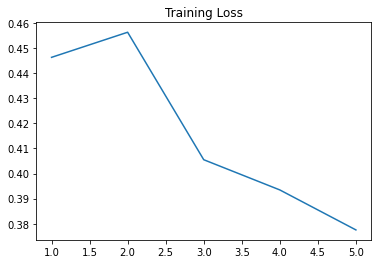

In [ ]:
# Drawing leaning curve 
diagram = []
for i in loss_list:
  print(i.item())
  it = i.item()
  diagram.append(it)
diagram

plt.title("Training Loss")
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), diagram)

In [ ]:
model.save_pretrained("best_model.pt")

In [ ]:
import evaluate
import torch

# evaluate.combine wasn't working well instead I called the metrics individually
metric = evaluate.load('accuracy') # accuracy, precision, f1

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])
metric.compute() # call this one for accuracy
#metric.compute(average='weighted') # call this one for f1 and precision

{'accuracy': 0.85315}

In [ ]:
metric = evaluate.load('accuracy')
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute() # call this one for accuracy
#metric.compute(average='weighted') # call this one for f1 and precision

{'accuracy': 0.854346875}

**# 85.43% accuracy on test set with 5 epochs only :) **

The method I used here is from my NLP with Deep Learning class F22-5980. 
At first I loaded and cleaned the csv file from the Kaggle with Pandas, but then realized that the same dataset exists on the Huggingface Dataset (train set in huggingface is the same as the whole csv in Kaggle).
The rest of the methods are using BERT as a pretrained model both for tokenization and embedding. 
**bold text**